In [1]:
## Install OpenCV to read images
## !pip install opencv-python

## PlantVillage Disease Classification Challenge

Followis is a entry level code to develop a classifier that can Identify crop species and disease, using a dataset of tens of thousands of expert labeled leaf images.

More about dataset: https://arxiv.org/abs/1511.08060

More about Project: https://www.crowdai.org/organizers/plantvillage

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


### Function to read image from file and convert to array

In [2]:
default_image_size = tuple((256, 256))
## Function to convert image to array of 256 X 256
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

### Load images from directory and create Image list and lable list

In this function,
- We will read each image from directory and convert them to array. Array of image is added to image_list

- Each image is read from directory, directory name is class lable. Class lable are read in lable_list.


In [12]:
image_list_a, label_list = [], []

totalImage = 0  # it is used to control total numbe of images for each class

root_dir = listdir("PlantVillage/") # Specify location of plant images

for image_folder in root_dir :  # Look for each folder
    # Look for All images in each folder
    image_list = listdir(f"PlantVillage/{image_folder}")
    
    for image in image_list:
        # Read each image in a variable image_list_a and 
        #correspoding folder name as image lable
        
        image_name = f"PlantVillage/{image_folder}/"+image
        if isinstance(image_name, str) == True:
            if image_name.endswith(".jpg") == True or image_name.endswith(".JPG") == True:
                image_list_a.append(convert_image_to_array(image_name))
                label_list.append(image_folder)
        totalImage = totalImage+1
        if(totalImage>=20):          
            break
            
print(len(label_list),len(np.unique(np.asarray(label_list))))
from sys import getsizeof
getsizeof(image_list_a)

34 15


344

### LabelBinarizer is used to encode lable list into onehot encoding

A one hot encoding is a representation of categorical variables as binary vectors. This first requires that the categorical values be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1

In [13]:
# Convert total 15 class to one hot encoding
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

### Data is split into train-test sets

In [14]:
# Split data in train and test
image_list_a = np.asarray(image_list_a)
x_train, x_test, y_train, y_test = train_test_split(image_list_a, image_labels, test_size=0.2, random_state = 42)

### Model Development
Here, some constants are defined which can be changed accoding to requiremtns.

Also, Model defined here is just initial model which can be further optimized to achive stable score for loss and accuracy.

In [15]:

EPOCHS = 10
INIT_LR = 1e-3
BS = 32
width=256
height=256
depth=3
inputShape = (height, width, depth)
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) 
chanDim = 1

# Develope  model
model = Sequential()
model.add(Conv2D(4, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(524))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 4)       112       
_________________________________________________________________
activation_4 (Activation)    (None, 256, 256, 4)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 4)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 85, 4)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 85, 85, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28900)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 524)               15144124  
__________

In [16]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

### Train a model

Fit function is used to train model with training samples.

fit_generator is used to train a model with spacial variations in data to capture data from diffeent perspective. 
Here fit_generator is not used.

In [17]:
'''history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )
'''
history = model.fit(x_train, y_train, batch_size=32,
    validation_data=(x_test, y_test),
    epochs=EPOCHS, verbose=1
    )


Train on 27 samples, validate on 7 samples
Epoch 1/10
27/27 [==============================] - 3s 121ms/step - loss: 0.3888 - acc: 0.9185 - val_loss: 1.8320 - val_acc: 0.8857
Epoch 2/10
27/27 [==============================] - 1s 46ms/step - loss: 0.1378 - acc: 0.9580 - val_loss: 1.4594 - val_acc: 0.8857
Epoch 3/10
27/27 [==============================] - 1s 46ms/step - loss: 0.0876 - acc: 0.9802 - val_loss: 1.2626 - val_acc: 0.8667
Epoch 4/10
27/27 [==============================] - 1s 45ms/step - loss: 0.0707 - acc: 0.9802 - val_loss: 0.8433 - val_acc: 0.8762
Epoch 5/10
27/27 [==============================] - 1s 45ms/step - loss: 0.0661 - acc: 0.9802 - val_loss: 0.6886 - val_acc: 0.8857
Epoch 6/10
27/27 [==============================] - 1s 44ms/step - loss: 0.0217 - acc: 1.0000 - val_loss: 0.7367 - val_acc: 0.9048
Epoch 7/10
27/27 [==============================] - 1s 46ms/step - loss: 0.0309 - acc: 0.9926 - val_loss: 0.5522 - val_acc: 0.9048
Epoch 8/10
27/27 [=====================

### Ploting accuracy and loss

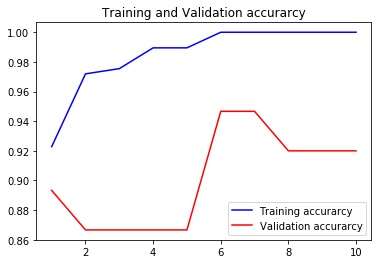

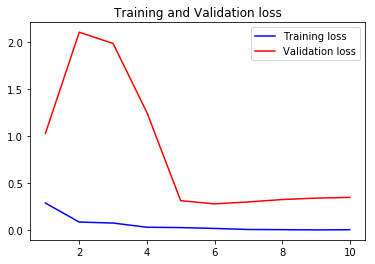

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 11ms/step


[0.9501399993896484, 0.8761904835700989]